In [219]:
# Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import warnings
import prince

from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")
sns.set()

## First look at the dataset

In [220]:
# Getting Data
df_people = pd.read_csv(r'Data/people.csv', index_col=0)
df_people.head(5)

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size
1,Male,No,22,No,Low,4
2,Female,Yes,38,Yes,Average,3
3,Female,Yes,67,Yes,Low,1
4,Male,Yes,67,Yes,High,2
5,Female,Yes,40,Yes,High,6


In [221]:
# Descriptive Statistics
df_people.describe()

,Age,Family_Size
count,7538.000000,7538.000000
mean,43.524144,2.845450
std,16.612202,1.527899
min,18.000000,1.000000
25%,31.000000,2.000000
50%,41.000000,3.000000
75%,53.000000,4.000000
max,89.000000,9.000000


In [222]:
# Separating Categorical and Numeric Data
df_people_num = df_people[['Age','Family_Size']]
df_people = df_people.drop(['Age', 'Family_Size'], 1)

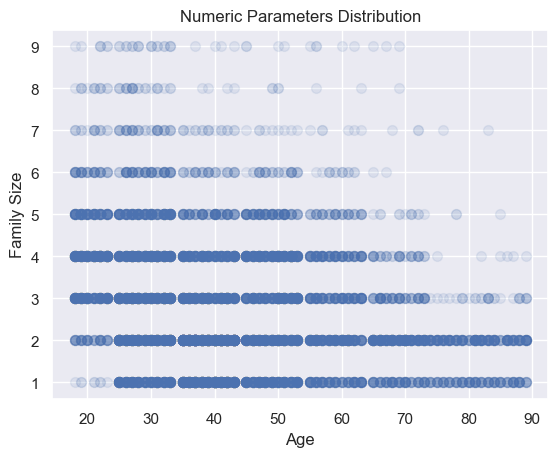

In [223]:
# Ploting the Numeric Values
plt.scatter(df_people_num['Age'], df_people_num['Family_Size'], alpha=.1, s=50)
plt.title('Numeric Parameters Distribution')
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.show()

In [224]:
# Normalizing Numeric parameters
scaler = StandardScaler()
df_people_num_normalized = scaler.fit_transform(df_people_num)

## K-means Clustering

In order to define the number of cluster the WCSS method (which is defined by the sum of the squared distance between each member of the cluster and its centroid) will be used.

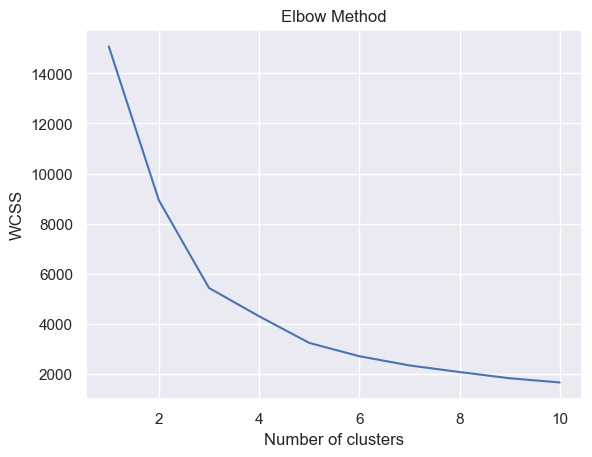

In [225]:
# Plotting the Elbow Method Graph
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_people_num_normalized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [226]:
# Applying Kmeans for generating 5 clusters
kmeans = KMeans(n_clusters=5, algorithm ='auto', init='random')
labels = kmeans.fit_predict(df_people_num_normalized)

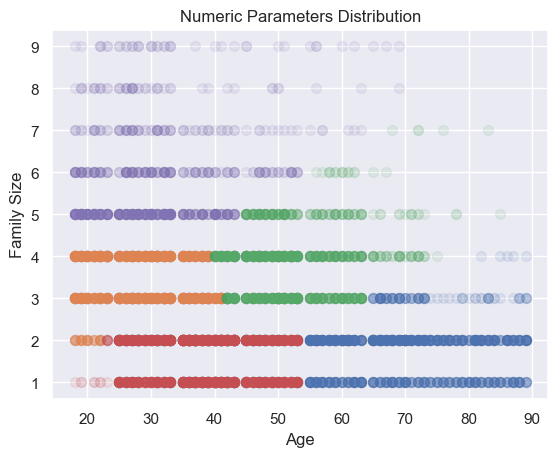

In [227]:
# Ploting the Numeric Values grouped by the clusters
df_people_num['c'] = labels
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==0], df_people_num['Family_Size'].loc[df_people_num['c']==0], alpha=.1, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==1], df_people_num['Family_Size'].loc[df_people_num['c']==1], alpha=.1, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==2], df_people_num['Family_Size'].loc[df_people_num['c']==2], alpha=.1, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==3], df_people_num['Family_Size'].loc[df_people_num['c']==3], alpha=.1, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==4], df_people_num['Family_Size'].loc[df_people_num['c']==4], alpha=.1, s=50)
plt.title('Numeric Parameters Distribution')
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.show()

In [228]:
# Adding the cluster to the categorical dataframe
df_people['Cluster'] = labels.astype(str)
df_people.head(5)

,Gender,Ever_Married,Graduated,Spending_Score,Cluster
1,Male,No,No,Low,1
2,Female,Yes,Yes,Average,1
3,Female,Yes,Yes,Low,0
4,Male,Yes,Yes,High,0
5,Female,Yes,Yes,High,4


All the dataframe parameters are categorical (even the cluster's column being 0, 1, ... they're categorical, could be replaced for 'A', 'B', ...).

## Multiple Correspondence Analysis

Multiple Match Analysis is based on the correspondence between columns. If there is a column with no significant correspondence to any other column it can be removed, the test uses the chi-square contingency value.

If the minimum match of a column to another column is less than 0.05, the column is retained.

In [230]:
# Testing the correspondence between columns
assosc_table = pd.DataFrame(index=df_people.columns, columns=df_people.columns)
for idx in assosc_table.index:
    for col in assosc_table.columns:
        if col != idx:
            contingency = df_people[[col, idx]].value_counts().reset_index().pivot(index=[col], columns=[idx])[0].fillna(0)
            assosc_table[col].loc[idx] = scipy.stats.chi2_contingency(contingency)[1]
assosc_table.min()

Gender            0.0
Ever_Married      0.0
Graduated         0.0
Spending_Score    0.0
Cluster           0.0
dtype: object

The MCA's outputs are a group of coordinates for each category of each parameter. The cordinates have *n* dimensions, where:

n = total categories - total parameters

In [251]:
# Number of dimensions
total_dimensions = 0
for column in df_people.columns:   
    total_dimensions += len(df_people[column].value_counts())
total_dimensions = total_dimensions - len(df_people.columns)

In [254]:
# Applying MCA for the dataset considering the all the possible dimensions
mca = prince.MCA(n_components = total_dimensions)
mca = mca.fit(df_people)

In [255]:
# Variance of each dimension
mca.explained_inertia_

[0.24496447609821306,
 0.14984612851807946,
 0.13205248647010634,
 0.11248964253919662,
 0.1034296812108587,
 0.08805826942454541,
 0.07641162756729036,
 0.0626088344820234,
 0.03013885368968628]

The sum of all the dimensions inertia represents 100% of the total variance.

In order to plot the Perceptual Map, the 2 most relevant dimentions will be used.

In [258]:
# Applying MCA for the dataset for 2 dimensions
mca = prince.MCA(n_components = 2)
mca = mca.fit(df_people)

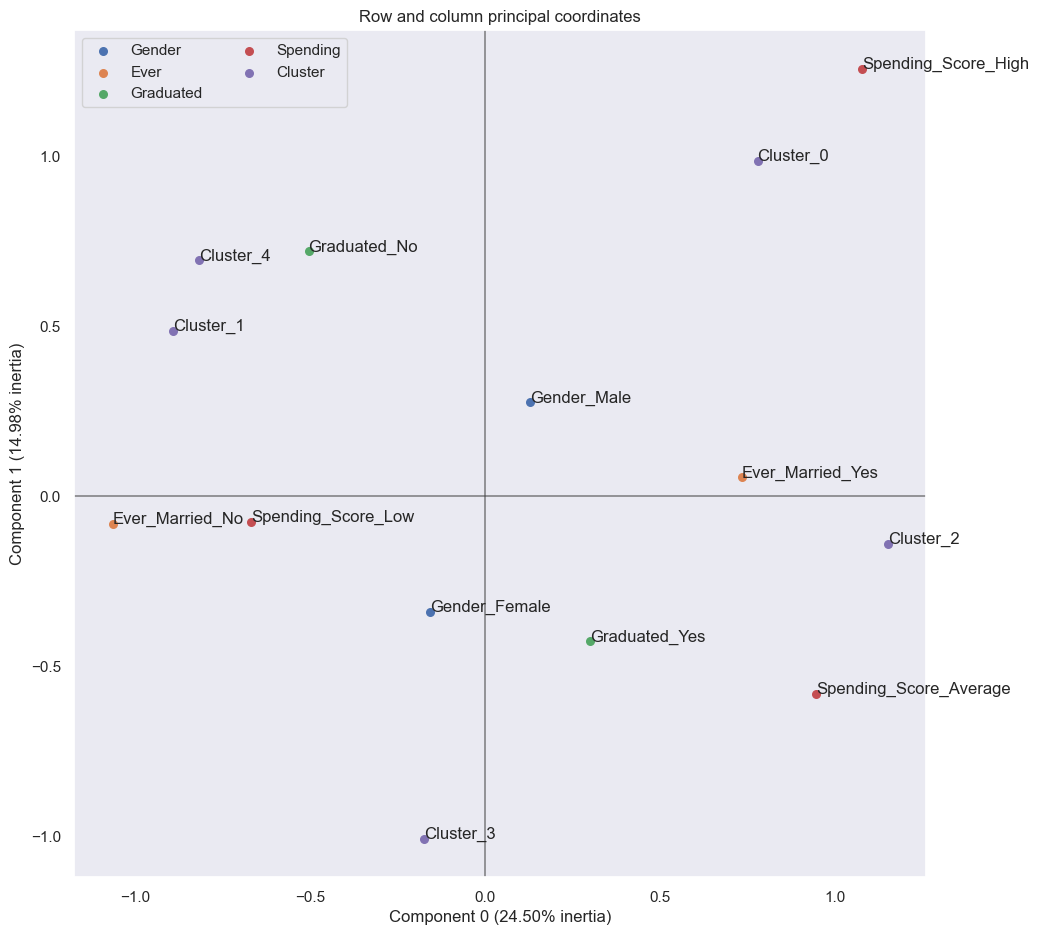

In [238]:
# Plotting Perceptual Map
ax = mca.plot_coordinates(X=df_people,show_row_points=False,
                          row_points_size=10,
                          show_row_labels=False,
                          show_column_points=True,
                          column_points_size=30,
                          figsize=(11,11),
                          show_column_labels=True,
                          legend_n_cols=2)

In [250]:
# Applying MCA
mca = prince.MCA(n_components = total_dimensions)
mca = mca.fit(df_people)
mca.explained_inertia_

[0.2449644760982127,
 0.14984612851807966,
 0.13205248647010637,
 0.11248964253919667,
 0.10342968121085865,
 0.08805826942454552,
 0.07641162756729043,
 0.06260883448202337,
 0.030138853689686326,
 1.2490953449117763e-32]

9

In [257]:
pd.Series(mca.explained_inertia_).sum()

0.9999999999999997